# AIAP11 EDA

### Loading required libraries

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from src.extract import ImportData
from config.config_load import read_yaml_file

### Loading dataset

In [20]:
# Reading in data location from config file
config = read_yaml_file()
data_location = config["data"]["data_location"]

# Calling the data from module 1
table = ImportData(data_location).return_table("noshow")
table

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,1.0,Changi,July,May,19.0,May,20.0,China,Yes,King,None,Email,2,1.0
1,0.0,Orchard,December,February,28.0,March,-4.0,India,Yes,None,USD$ 723.34,Email,1,0.0
2,0.0,Orchard,December,May,22.0,May,24.0,Australia,Yes,Single,SGD$ 650.94,Website,1,0.0
3,0.0,Orchard,October,September,2.0,September,4.0,China,Yes,None,SGD$ 978.67,Agent,1,1.0
4,0.0,Orchard,February,February,7.0,February,8.0,China,Yes,King,None,Website,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,0.0,Changi,October,March,17.0,March,19.0,China,Yes,King,SGD$ 953.94,Email,2,1.0
119387,0.0,Changi,August,June,2.0,June,3.0,Indonesia,Yes,King,USD$ 636.84,Email,1,1.0
119388,0.0,Changi,January,July,1.0,July,3.0,Indonesia,Yes,King,None,Website,1,0.0
119389,0.0,Changi,January,May,26.0,May,29.0,Indonesia,Yes,King,USD$ 720.1,Email,1,1.0


### Basic Data Description

Wanted to look at:
1. Types of categories within the dataset and if they were classified correctly 
2. Column names and information if it tallies with information provided by AISG 
3. Any other salient information that might suggest how data was captured and how it was put together

In [21]:
num_cat = table.select_dtypes(include=[np.number])
cat_cat = table.select_dtypes(include="object")
for each in cat_cat:
    table[each] = table[each].astype("category")

print(f"There are {table.shape[1]} columns in the dataset with {table.shape[0]} observations")
print(f"There are {num_cat.shape[1]} numerical columns and {cat_cat.shape[1]} categorical columns in the dataset")
print(f"There are {table.isna().sum().sum()} empty observations in dataset")

There are 14 columns in the dataset with 119391 observations
There are 4 numerical columns and 10 categorical columns in the dataset
There are 46507 empty observations in dataset


In [22]:
table.columns

Index(['no_show', 'branch', 'booking_month', 'arrival_month', 'arrival_day',
       'checkout_month', 'checkout_day', 'country', 'first_time', 'room',
       'price', 'platform', 'num_adults', 'num_children'],
      dtype='object')

In [23]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119391 entries, 0 to 119390
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   no_show         119390 non-null  float64 
 1   branch          119390 non-null  category
 2   booking_month   119390 non-null  category
 3   arrival_month   119390 non-null  category
 4   arrival_day     119390 non-null  float64 
 5   checkout_month  119390 non-null  category
 6   checkout_day    119390 non-null  float64 
 7   country         119390 non-null  category
 8   first_time      119390 non-null  category
 9   room            97778 non-null   category
 10  price           94509 non-null   category
 11  platform        119390 non-null  category
 12  num_adults      119390 non-null  category
 13  num_children    119390 non-null  float64 
dtypes: category(10), float64(4)
memory usage: 7.6 MB


### Data Cleaning and Preprocessing
Observations
1. Separate price into currency and value to allow for better comparison (database parsing error)
2. Remove one row that was completly empty within the dataset row number: 115536 (data-entry error)
3. "num_adults" was a freetext field, hence changed [1,2,"one", "two"] within series into [1,2] (data-entry error)
4. Several columns was saved as float in database but should have been integers 
5. "first_time" should be converted to boolean [True, False]
6. "no_show" should be converted to boolean [True, False]
7. There are some checkout days which are negative in value, processed to return positive (date-entry error)
8. There seems to be different naming conventions for months []

In [24]:
# 1. Separate price into currency and value to allow for better comparison
# Identify the prices which have "None" and replace with np.nan
table.price.replace(["None", "nan"], np.nan)

# Split out currency from room price
table["currency"] = table.price.apply(lambda x: np.nan if x=="None" else x[:3]).astype("category")

# Split out price from price
def split_price(price):
    """Parse out the relevant price from the series
    Args:
        price (string): price with full currency and price 
    Returns:
        price: float point price
    """
    if price == "None" or price is None:
        return np.nan
    else:
        return float(price[5:])

table["price"] = table.price.apply(lambda x: split_price(x))

# Convert to a single currency base, SGD, historical average currency exchange of 1.3439 was used
table["SGD_price"] = np.where(table["currency"] == "USD", round(table["price"]*1.3439,2) , table["price"])

In [25]:
# 2. Remove one row that was completely empty within the dataset row number: 115536
# table shape before
print(f"table shape before processing {table.shape}")

# Viewing sliced table with empty data
table.loc[table.no_show.isna()]

# Removing empty data line
# table.iloc[table.index[115536], :]
table.drop(table.index[115536], inplace=True)

# Checking table shape after removal
print(f"table shape after processing {table.shape}")

table shape before processing (119391, 16)
table shape after processing (119390, 16)


In [26]:
# 3. "num_adults" was a freetext field, hence changed [1,2,"one", "two"] within series into [1,2]
# changing number of adults to integers
def chg_to_num(num):
    """Change numbers from string to integers for use in lambda only
    Args:
        num (string): string version of integer
    Returns:
        num: numerical version of string integer
    """
    if num is None:
        return np.nan
    elif num=="one":
        return int(1)
    elif num=="two":
        return int(2)
    else:
        return int(num)

table["num_adults"] = table.num_adults.apply(lambda x: chg_to_num(x))

In [27]:
# 4. Several columns was saved as float in database but should have been integers  ["num_adults", "arrival_day", "checkout_day", "num_children"]
# columns that needs to be changed to integers
int_cols = ["num_adults", "arrival_day", "checkout_day", "num_children"]

# Changed all other data from float to categorical
table[int_cols] = table[int_cols].astype("int")

In [28]:
# 5. "first_time" should be converted to boolean [1,0]
# change first_time to either 1 for "Yes" or 0 for "No"
table["first_time"] = table["first_time"].apply(lambda x: True if x =="Yes" else False)

In [29]:
# 6. "no_show" should be converted to boolean [1,0]
# change first_time to either 1 for "Yes" or 0 for "No"
table["no_show"] = table["no_show"].apply(lambda x: True if x==1 else False)

In [30]:
# 7. There are some checkout days which are negative in value
def checkout_neg(num):
    """For each day provided return the absolute number
    Args:
        num (integer): checkout day provided
    Returns:
        num: absolute value of number given
    """
    if num<0:
        return abs(num)
    else:
        return num

table["checkout_day"] = table.checkout_day.apply(lambda x: checkout_neg(x))

In [31]:
# 8. There seems to be different cases for the same months ['September', 'SepTember', 'SeptemBer']
def title_case(month):
    """Change input into titlecase 
    Args:
        month (string): month input
    Returns:
        month: month in title case
    """
    if isinstance(month, str):
        return month.title()

table["arrival_month"] = table["arrival_month"].apply(lambda x: title_case(x)).astype("category")

In [32]:
df = table.copy()
df

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,currency,SGD_price
0,True,Changi,July,May,19,May,20,China,True,King,NaN,Email,2,1,NaN,NaN
1,False,Orchard,December,February,28,March,4,India,True,NaN,723.34,Email,1,0,USD,972.10
2,False,Orchard,December,May,22,May,24,Australia,True,Single,650.94,Website,1,0,SGD,650.94
3,False,Orchard,October,September,2,September,4,China,True,NaN,978.67,Agent,1,1,SGD,978.67
4,False,Orchard,February,February,7,February,8,China,True,King,NaN,Website,1,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,False,Changi,October,March,17,March,19,China,True,King,953.94,Email,2,1,SGD,953.94
119387,False,Changi,August,June,2,June,3,Indonesia,True,King,636.84,Email,1,1,USD,855.85
119388,False,Changi,January,July,1,July,3,Indonesia,True,King,NaN,Website,1,0,NaN,NaN
119389,False,Changi,January,May,26,May,29,Indonesia,True,King,720.10,Email,1,1,USD,967.74


### Exploratory Data Analysis

#### Relook Objectives of application
- **"Predict the No-Show** of customers to help a hotel chain to formulate policies to **reduce expenses incurred** due to No-Shows"

---
#### EDA Thought process
1. What features should we be looking out for and what feature engineering needs to be done? 
    1. [x] Are those with children more or less likely to no-show?
    2. [x] Are there specific countries that are more likely to no-show?
    3. [ ] Which months are no-shows more likely?
        - a. [ ] arrival month 
        - b. [ ] checkout month 
    4. [ ] Is there a difference in no-show between booking platforms?
    5. [x] Are first time customers more likely to no-show?
    6. [x] Is low room price a reason for no-show?


   no_show  branch  percentage
0    False   75166       62.96
1     True   44224       37.04


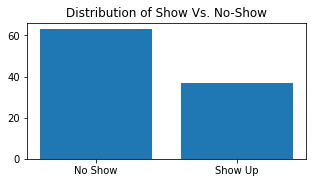

In [33]:
# Check id dataset is imbalanced
imb = df.groupby("no_show")["branch"].count().reset_index()
imb["percentage"] = round((imb.branch / imb.branch.sum()) *100,2)
print(imb)

# Plotting result of check
plt.figure(figsize = (5,2.5))
plt.title("Distribution of Show Vs. No-Show")
plt.bar(imb.no_show, imb.percentage, tick_label=["No Show", "Show Up"])
plt.show()

In [34]:
# 1. Are those with children more or less likely to no-show?
df["with_child"] = df.num_children.apply(lambda x: True if x>0 else False)
child = df.groupby("with_child")["no_show"].sum().reset_index()
child["percentage"] = round((child.no_show / child.no_show.sum()) *100,2)

print(child)
print(f"Those with children have a {child.iloc[1,-1]}% chance of no show vs those without children {child.iloc[0,-1]}%")


   with_child  no_show  percentage
0       False    16264       36.78
1        True    27960       63.22
Those with children have a 63.22% chance of no show vs those without children 36.78%


In [35]:
# 2. Are there specific countries that are more likely to no-show?
country = df.groupby("country")["no_show"].agg(["sum", "count"]).reset_index()
country["pct_no_show"] = round((country["sum"]/country["count"])*100,2)
country["prop_no_show"] = round((country["sum"]/country["sum"].sum())*100,2)
country = country.sort_values("pct_no_show", ascending=False).reset_index(drop=True)

print(country)
print(f"There seems to be a high proportion of customers from {country.iloc[0, 0]} and {country.iloc[1, 0]} who dont turn up")
print(f"However in terms of overall volume customers from {country.iloc[0, 0]} and {country.iloc[2, 0]} form the largest bulk of no show customers")

     country    sum  count  pct_no_show  prop_no_show
0      China  27519  48590        56.64         62.23
1   Malaysia   1333   3766        35.40          3.01
2  Indonesia   6894  25812        26.71         15.59
3  Singapore    939   3912        24.00          2.12
4      India   3481  15790        22.05          7.87
5  Australia   2453  12129        20.22          5.55
6      Japan   1605   9391        17.09          3.63
There seems to be a high proportion of customers from China and Malaysia who dont turn up
However in terms of overall volume customers from China and Indonesia form the largest bulk of no show customers


In [41]:
# 3.a Which months are no-shows more likely?
months_arr = df.groupby("arrival_month")["no_show"].agg(["sum", "count"]).reset_index()
months_arr["pct_no_show"] = round((months_arr["sum"]/months_arr["count"])*100,2)
print(months_arr.sort_values("pct_no_show", ascending=False))

print(f"The mean {round(months_arr.pct_no_show.mean(),2)}% is close to overall dataset {imb.iloc[1,2]}%")
print(f"There is no obvious trend between arrival month and no shows")

   arrival_month   sum  count  pct_no_show
6           June  4535  10939        41.46
0          April  4524  11089        40.80
8            May  4677  11791        39.67
11     September  4116  10508        39.17
10       October  4246  11160        38.05
1         August  5239  13877        37.75
5           July  4742  12661        37.45
2       December  2371   6780        34.97
3       February  2696   8068        33.42
7          March  3149   9794        32.15
9       November  2122   6794        31.23
4        January  1807   5929        30.48
The mean 36.38% is close to overall dataset 37.04%
There is no obvious trend between arrival month and showing up


In [43]:
# 3.a Which months are no-shows more likely?
months_checkout = df.groupby("checkout_month")["no_show"].agg(["sum", "count"]).reset_index()
months_checkout["pct_no_show"] = round((months_checkout["sum"]/months_checkout["count"])*100,2)
print(months_checkout.sort_values("pct_no_show", ascending=False))

print(f"The mean {round(months_checkout.pct_no_show.mean(),2)}% is close to overall dataset {imb.iloc[1,2]}%")
print(f"There is no obvious trend between checkout month and no shows")

   checkout_month   sum  count  pct_no_show
6            June  4497  10692        42.06
0           April  4398  11016        39.92
8             May  4790  12044        39.77
11      September  4003  10416        38.43
10        October  4390  11434        38.39
1          August  5245  13836        37.91
5            July  4803  12760        37.64
2        December  2184   6237        35.02
7           March  3097   9509        32.57
3        February  2508   7716        32.50
9        November  2300   7214        31.88
4         January  2009   6516        30.83
The mean 36.41% is close to overall dataset 37.04%
There is no obvious trend between arrival month and showing up


In [42]:
# 4. Is there a difference in no-show between booking platforms?
platform = df.groupby("platform")["no_show"].agg(["sum", "count"]).reset_index()
platform["pct_no_show"] = round((platform["sum"]/platform["count"])*100,2)

print(platform.sort_values("pct_no_show",ascending=False))
print(f"The mean percentage across all platfoms is {platform.pct_no_show.mean()}%, which is close to overall dataset {imb.iloc[1,2]}%")
print(f"There is no obvious trend between platform and not showing up")

  platform    sum  count  pct_no_show
1    Email  12214  32608        37.46
0    Agent   8039  21735        36.99
3  Website  20050  54234        36.97
2    Phone   3921  10813        36.26
The mean percentage across all platfoms is 36.92%, which is close to overall dataset 37.04%
There is no obvious trend between platform and not showing up


In [39]:
# 5. Are first time customers more likely to no-show?
first = df.groupby("first_time")["no_show"].agg(["sum", "count"]).reset_index()
first["pct_no_show"] = round((first["sum"]/first["count"])*100,2)
first["prop_no_show"] = round((first["sum"]/first["sum"].sum())*100,2)

print(first)
print(f"First time customers make up the overwhelming proportion of no show at {first.iloc[1,-1]}%")

  first_time    sum   count  pct_no_show  prop_no_show
0      False    552    3810        14.49          1.25
1       True  43672  115580        37.79         98.75
First time customers make up the overwhelming proportion of no show at 98.75%


count    94509.000000
mean       940.132582
std        263.545100
min        392.430000
25%        816.310000
50%        903.830000
75%        998.180000
max       2099.960000
Name: SGD_price, dtype: float64
The interquartile range is 605.75
2099.96 998.18 903.83 816.31 392.43
The bottom bound (-1.5*IQR) is -516.19 and the top bound (+1.5*IQR) is 1906.8


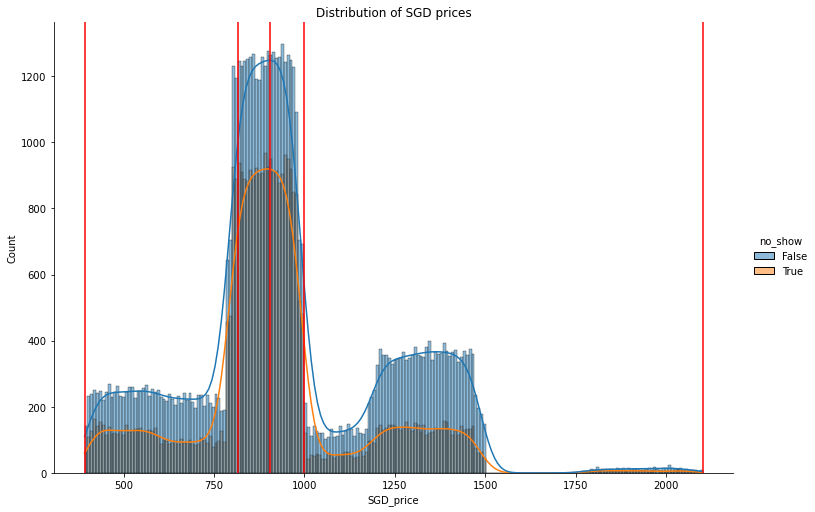

From the distribution plot we can see that the distribution of the no show is inline with distribution of prices


In [63]:
# 6. Is low room price a reason for no-show?
# What is the average, minimum and maximum prices?")
print(df.SGD_price.describe())

# Due to the high outlier the limit of the boxplot was limited to the top bound of the interquartile range 
q4, q3, qm, q2, q1 = np.nanpercentile(df.SGD_price, [100, 75, 50, 25, 0])
price_iqr = round(q3-q1,2)
top_bound = round(q3+1.5*price_iqr,2)
btm_bound = round(q1-1.5*price_iqr,2)
print(f"The interquartile range is {price_iqr}")
print(q4, q3, qm, q2, q1)
print(f"The bottom bound (-1.5*IQR) is {btm_bound} and the top bound (+1.5*IQR) is {top_bound}")

# Boxplot
sns.displot(data=df, x="SGD_price", hue="no_show", kde=True, height=7, aspect=12/8).set(title="Distribution of SGD prices")
plt.axvline(q1, 0, 1200, color="red")
plt.axvline(q2, 0, 1200, color="red")
plt.axvline(qm, 0, 1200, color="red")
plt.axvline(q3, 0, 1200, color="red")
plt.axvline(q4, 0, 1200, color="red")
plt.show()

print(f"From the distribution plot we can see that the distribution of the no show is inline with distribution of prices")

  price_types    sum  count  pct_no_show
0      Lowest   5465  16716        32.69
1       Lower  24453  59371        41.19
2       Upper   4824  17711        27.24
3        High    231    711        32.49
First time customers make up the overwhelming proportion of no show at 41.19%


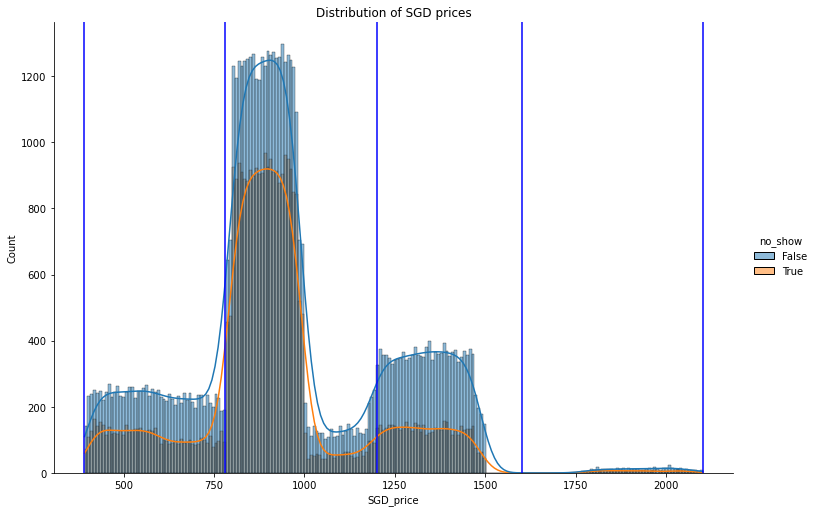

In [65]:
# Bin the SGD prices according to [0-25, 25-50, 50-75, 75-100] values
bins = [391, 780, 1200, 1600, 2100 ]
labels = ["Lowest", "Lower", "Upper", "High"]
df["price_types"] = pd.cut(df.SGD_price, bins, labels=labels)

#
pricetypes = df.groupby("price_types")["no_show"].agg(["sum", "count"]).reset_index()
pricetypes["pct_no_show"] = round((pricetypes["sum"]/pricetypes["count"])*100,2)

print(pricetypes)
print(f"First time customers make up the overwhelming proportion of no show at {pricetypes.iloc[1,-1]}%")

# Boxplot
sns.displot(data=df, x="SGD_price", hue="no_show", kde=True, height=7, aspect=12/8).set(title="Distribution of SGD prices")
plt.axvline(391, 0, 1200, color="blue")
plt.axvline(780, 0, 1200, color="blue")
plt.axvline(1200, 0, 1200, color="blue")
plt.axvline(1600, 0, 1200, color="blue")
plt.axvline(2100, 0, 1200, color="blue")
plt.show()

### Feature Engineering

#### Model Building Thought Process
- Prediction of No-Show clearly means that a **Classifier Model** is required
- Addressing classifier model weaknesses
    - Imbalance dataset
        - Dataset is not overly skwed towards either show or no show
        - No show being around 37.04% of overall bookings
            - Average cancellation rate on Booking.com and Expedia were 39% and 25% respectively [link](https://www.hoteliga.com/en/blog/how-to-reduce-no-shows-at-your-hotel)
    - What metrics to use?
        - Optimize for accuracy?
            - Should optimize for precision - within those that we classified as no-show, how many of them are indeed no-show
        - Impact of False Positive (Type 1 error)?
            - For a reputable hotel chain the cost of a type 1 error is extremely high. 
            - Customers who booked and paid deposits would be disappointed if rooms are not ready or worse no-rooms available
        - Impact of False Negative (Type 2 error)?
            - Cost is limited to current ops cost (cost of leaving room vacant due to no-show)  